* Data from https://opendata.dwd.de/climate_environment/CDC/event_catalogues/germany/precipitation/CatRaRE_v2023.01/data/CatRaRE_2001_2022_W3_Eta_v2023_01.gdb.zip

In [2]:
using GeoDataFrames,GeoJSON,ArchGDAL

In [3]:
layer=ArchGDAL.getlayer(ArchGDAL.read("CatRaRE_2001_2022_W3_Eta_v2023_01.gdb"),1)

Layer: CatRaRE_2001_2022_W3_Eta_EventZones_v2023_01
  Geometry 0 (Shape): [wkbMultiPolygon], MULTIPOLYGON (((-161...), ...
     Field 0 (CatVersion): [OFTString], W3_Eta_2023.01, W3_Eta_2023.01, ...
     Field 1 (KEY_FIELD): [OFTString], W3_Eta_1, W3_Eta_2, W3_Eta_3, ...
     Field 2 (Event_ID): [OFTInteger], 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...
     Field 3 (Start_Time): [OFTReal], 2.0010102035e11, 2.0010104035e11, ...
     Field 4 (End_Time): [OFTReal], 2.0010102075e11, 2.0010106035e11, ...
...
 Number of Fields: 69

In [4]:
using DataFrames

In [5]:
df=DataFrame(layer);

In [6]:
using GLMakie,GeoMakie

In [7]:
proj_string="+proj=stere +lat_0=90 +lat_ts=90 +lon_0=10 +k=0.93301270189 +x_0=0 +y_0=0 +a=6370040 +b=6370040  +no_defs"

"+proj=stere +lat_0=90 +lat_ts=90 +lon_0=10 +k=0.93301270189 +x_0=0 +y_0=0 +a=6370040 +b=6370040  +no_defs"

In [8]:
webmercator_string="+proj=webmerc +datum=WGS84"

"+proj=webmerc +datum=WGS84"

In [9]:
latlon_string="+proj=longlat +datum=WGS84 +no_defs +type=crs"

"+proj=longlat +datum=WGS84 +no_defs +type=crs"

In [10]:
using Proj

In [11]:
ArchGDAL.createcoordtrans(ArchGDAL.importPROJ4(proj_string), ArchGDAL.importPROJ4(webmercator_string)) do transform
    for x in eachrow(df)
    ArchGDAL.transform!(x.Shape, transform)
    end
end

In [12]:
boundary=GeoDataFrames.read("../Kreisgrenzen_2021_mit_Einwohnerzahl.geojson");

In [13]:
#dadi=boundary[(boundary.GEN.=="Darmstadt").|(boundary.GEN.=="Darmstadt-Dieburg"),:]
dadi=boundary[(boundary.GEN.=="Darmstadt"),:]

Row,geometry,OBJECTID,OBJID,BEGINN,AGS,GEN,BEZ,IBZ,BEM,SN_L,SN_R,SN_K,SN_V1,SN_V2,SN_G,FK_S3,NUTS,WSK,EWZ,KFL,SHAPE_Length,SHAPE_Area
,IGeometr…,Int32,String,DateTime,String,String,String,Int32,String,String,String,String,String,String,String,String,String,DateTime,Int32,Float64,Float64,Float64
1,Geometry: wkbMultiPolygon,117,DEBKGVG200000CAD,2022-01-05T00:00:00,06411,Darmstadt,Kreisfreie Stadt,40,--,06,4,11,00,00,000,R,DE711,1977-01-01T00:00:00,159631,122.07,0.722813,0.0153565


In [14]:
ArchGDAL.createcoordtrans(ArchGDAL.importPROJ4(latlon_string), ArchGDAL.importPROJ4(webmercator_string)) do transform
    for x in eachrow(dadi)
    ArchGDAL.transform!(x.geometry, transform)
    end
end

In [15]:
intersects=Vector{ArchGDAL.IGeometry{ArchGDAL.wkbMultiPolygon}}()
colors=[]
for x in dadi.geometry

    for y in eachrow(df)
        
        if ArchGDAL.intersects(x,y.Shape)
            intersects=vcat(intersects,y.Shape)
            push!(colors,y.RRmax)
        end
    end
end

In [16]:
using Tyler, Extents

In [17]:
using TileProviders

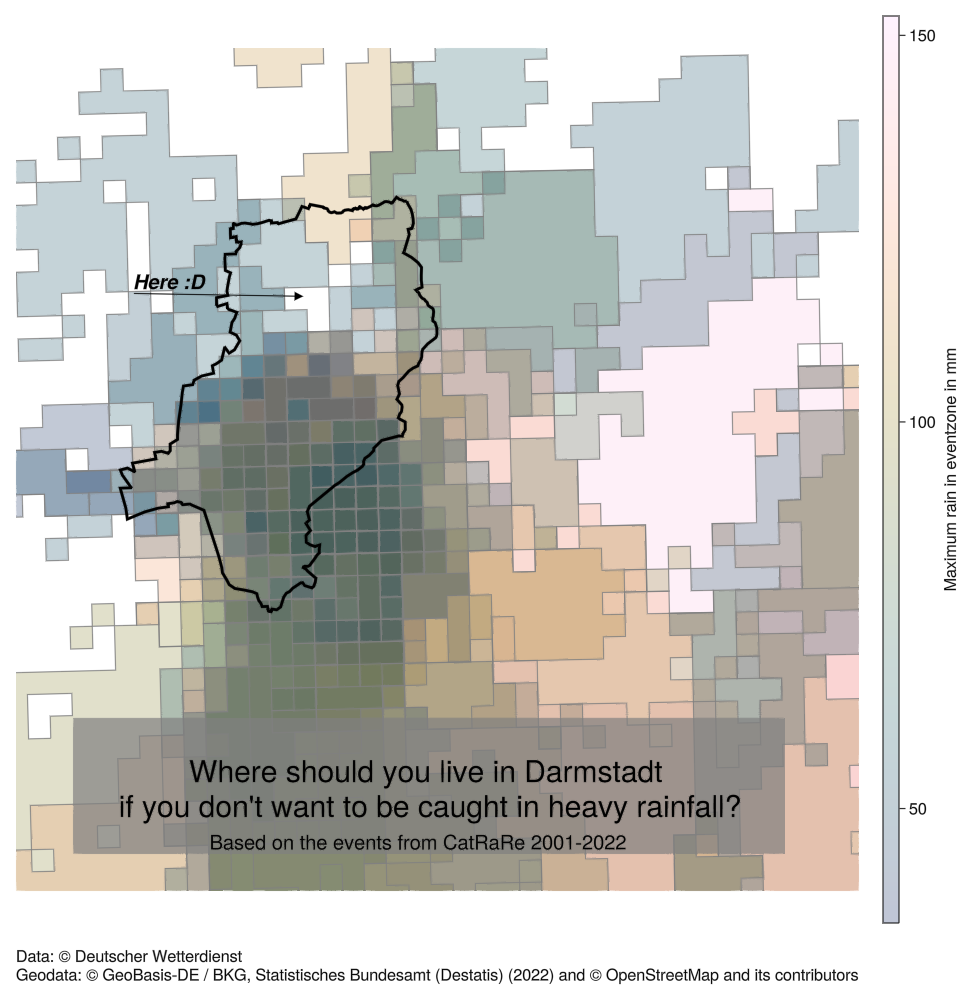

In [100]:
dadi_extent=Extent(X=(8.5,9.0),Y=(49.7,50.0))
m = Tyler.Map(dadi_extent;provider=TileProviders.OpenStreetMap())
p=poly!(m.axis,GeoMakie.to_multipoly.(GeoMakie.geo2basic(intersects)),color=colors,colormap=cgrad(:batlow,alpha=0.25,rev=false),strokecolor=:gray,strokewidth=1)
poly!(m.axis,GeoMakie.to_multipoly.(GeoMakie.geo2basic.(dadi.geometry)),color=:transparent,strokecolor=:black,strokewidth=3)
ax=m.axis
fig=m.figure

#q=GridLayout(fig[2,1])
#Label(q[1,1],text="Where should you live in Darmstadt \nif you don't want to be caught in heavy rainfall?",fontsize=30)
#Label(q[2,1],text="Based on the events from CatRaRe 2001-2022",fontsize=20)
hidespines!(ax)
#ci=poly!(Circle(Point2f(9.7*10^5, 6.425*10^6), 25000f0), color = :pink)
hidedecorations!(ax)
Colorbar(fig[1,2],p,vertical=true,label="Maximum rain in eventzone in mm")
a=arrows!(ax,[9.54*10^5],[6.432*10^6],[90],[-1.5],lengthscale=120,markerwidth=40)
t=text!(Point2f(9.54*10^5,6.432*10^6),text="Here :D",fontsize=20,font=:bold_italic)
poly!(Rect2(9.5*10^5,6.395*10^6,47000,9000),color=cgrad(:grays,alpha=0.7)[0.5])
t2=text!(Point2f(9.53*10^5,6.397*10^6),text="Where should you live in Darmstadt \nif you don't want to be caught in heavy rainfall?",fontsize=30,justification=:center)
t2=text!(Point2f(9.59*10^5,6.395*10^6),text="Based on the events from CatRaRe 2001-2022",fontsize=20,justification=:center)
translate!(t,0,0,10000)
translate!(a,0,0,10000)
#translate!(ci,0,0,10000)
translate!(p,0,0,-80)
Label(fig[2,1],text="Data: © Deutscher Wetterdienst\nGeodata: © GeoBasis-DE / BKG, Statistisches Bundesamt (Destatis) (2022) and © OpenStreetMap and its contributors",justification=:left)
Makie.resize_to_layout!(fig)
wait(m)


In [96]:
save("catrare_darmstadt.png",fig,px_per_unit=2)

In [ ]:
TileProviders